In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_9.csv")


In [24]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["customTime"] = dataFrame["customTime"].astype(float)
dataFrame["mpiTime"] = dataFrame["mpiTime"].astype(float)
dataFrame["checksum"] = dataFrame["checksum"].astype(object)

print("Rows:", len(dataFrame))
print("Ops:", dataFrame["opName"].unique())
print("Sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Procs:", sorted(dataFrame["numProcesses"].unique()))


Rows: 504
Ops: ['bcast' 'reduce' 'scatter' 'gather' 'allgather' 'alltoall']
Sizes: [1, 16, 1024, 16384, 65536, 262144, 1048576]
Procs: [1, 2, 4, 8]


In [25]:
grouped = dataFrame.groupby(["opName","messageSizeBytes","numProcesses"], as_index=False).agg(
    medianCustom = ("customTime","median"),
    medianMpi    = ("mpiTime","median"),
    stdCustom    = ("customTime","std"),
    stdMpi       = ("mpiTime","std"),
    count        = ("customTime","count")
)
grouped["stdCustom"] = grouped["stdCustom"].fillna(0.0)
grouped["stdMpi"] = grouped["stdMpi"].fillna(0.0)
grouped = grouped.sort_values(["opName","messageSizeBytes","numProcesses"]).reset_index(drop=True)
grouped.head(12)


,opName,messageSizeBytes,numProcesses,medianCustom,medianMpi,stdCustom,stdMpi,count
0,allgather,1,1,3.900000e-08,4.200000e-08,4.358899e-09,4.163332e-09,3
1,allgather,1,2,3.710000e-07,2.320000e-07,2.421432e-08,9.609024e-09,3
2,allgather,1,4,1.113000e-06,5.560000e-07,1.401154e-07,4.147690e-08,3
3,allgather,1,8,1.866000e-06,9.690000e-07,1.854625e-07,5.953430e-08,3
4,allgather,16,1,4.000000e-08,4.200000e-08,5.686241e-09,3.605551e-09,3
5,allgather,16,2,3.650000e-07,2.330000e-07,1.877054e-08,1.552417e-08,3
6,allgather,16,4,8.570000e-07,4.990000e-07,5.054041e-08,1.625833e-08,3
7,allgather,16,8,1.950000e-06,9.530000e-07,1.428708e-06,1.305118e-08,3
8,allgather,1024,1,4.200000e-08,4.700000e-08,4.509250e-09,6.928203e-09,3
9,allgather,1024,2,6.460000e-07,3.610000e-07,2.986637e-08,3.121431e-08,3


In [26]:
def computeSpeedupEfficiencyForMedian(baseGrouped, medianColName, stdColName):
    frames = []
    for (opVal, messageSizeVal), subFrame in baseGrouped.groupby(["opName","messageSizeBytes"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows[medianColName].values[0])
        subFrame = subFrame.copy()
        subFrame = subFrame.assign(median = subFrame[medianColName].astype(float))
        if stdColName in subFrame.columns:
            subFrame["std"] = subFrame[stdColName].astype(float).fillna(0.0)
        else:
            subFrame["std"] = 0.0
        subFrame["speedup"] = np.where(subFrame["median"] > 0, baseTime / subFrame["median"], np.nan)
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrameCustom = computeSpeedupEfficiencyForMedian(grouped, "medianCustom", "stdCustom")
perfFrameMpi    = computeSpeedupEfficiencyForMedian(grouped, "medianMpi",    "stdMpi")

print("perfFrameCustom rows:", len(perfFrameCustom))
print("perfFrameMpi rows:", len(perfFrameMpi))

perfFrameCustom rows: 168
perfFrameMpi rows: 168


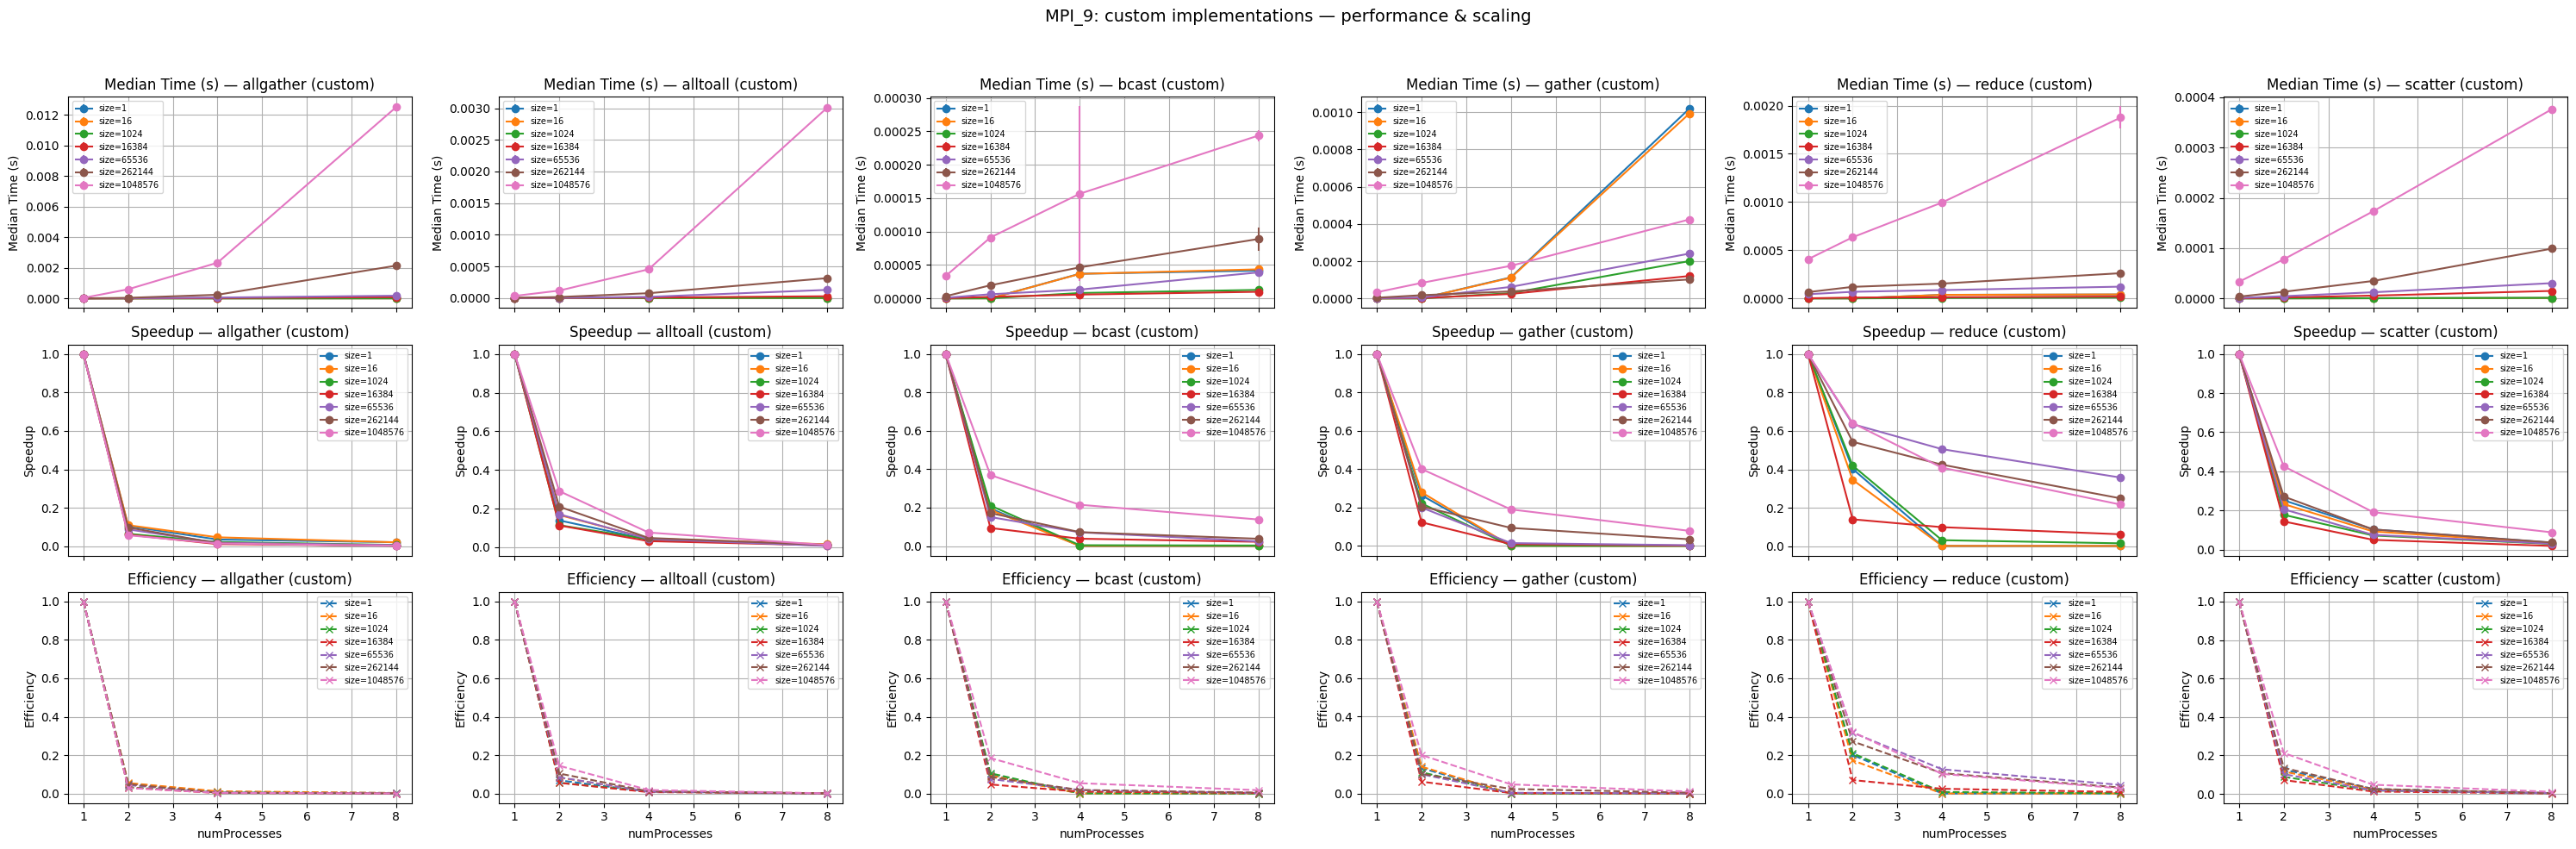

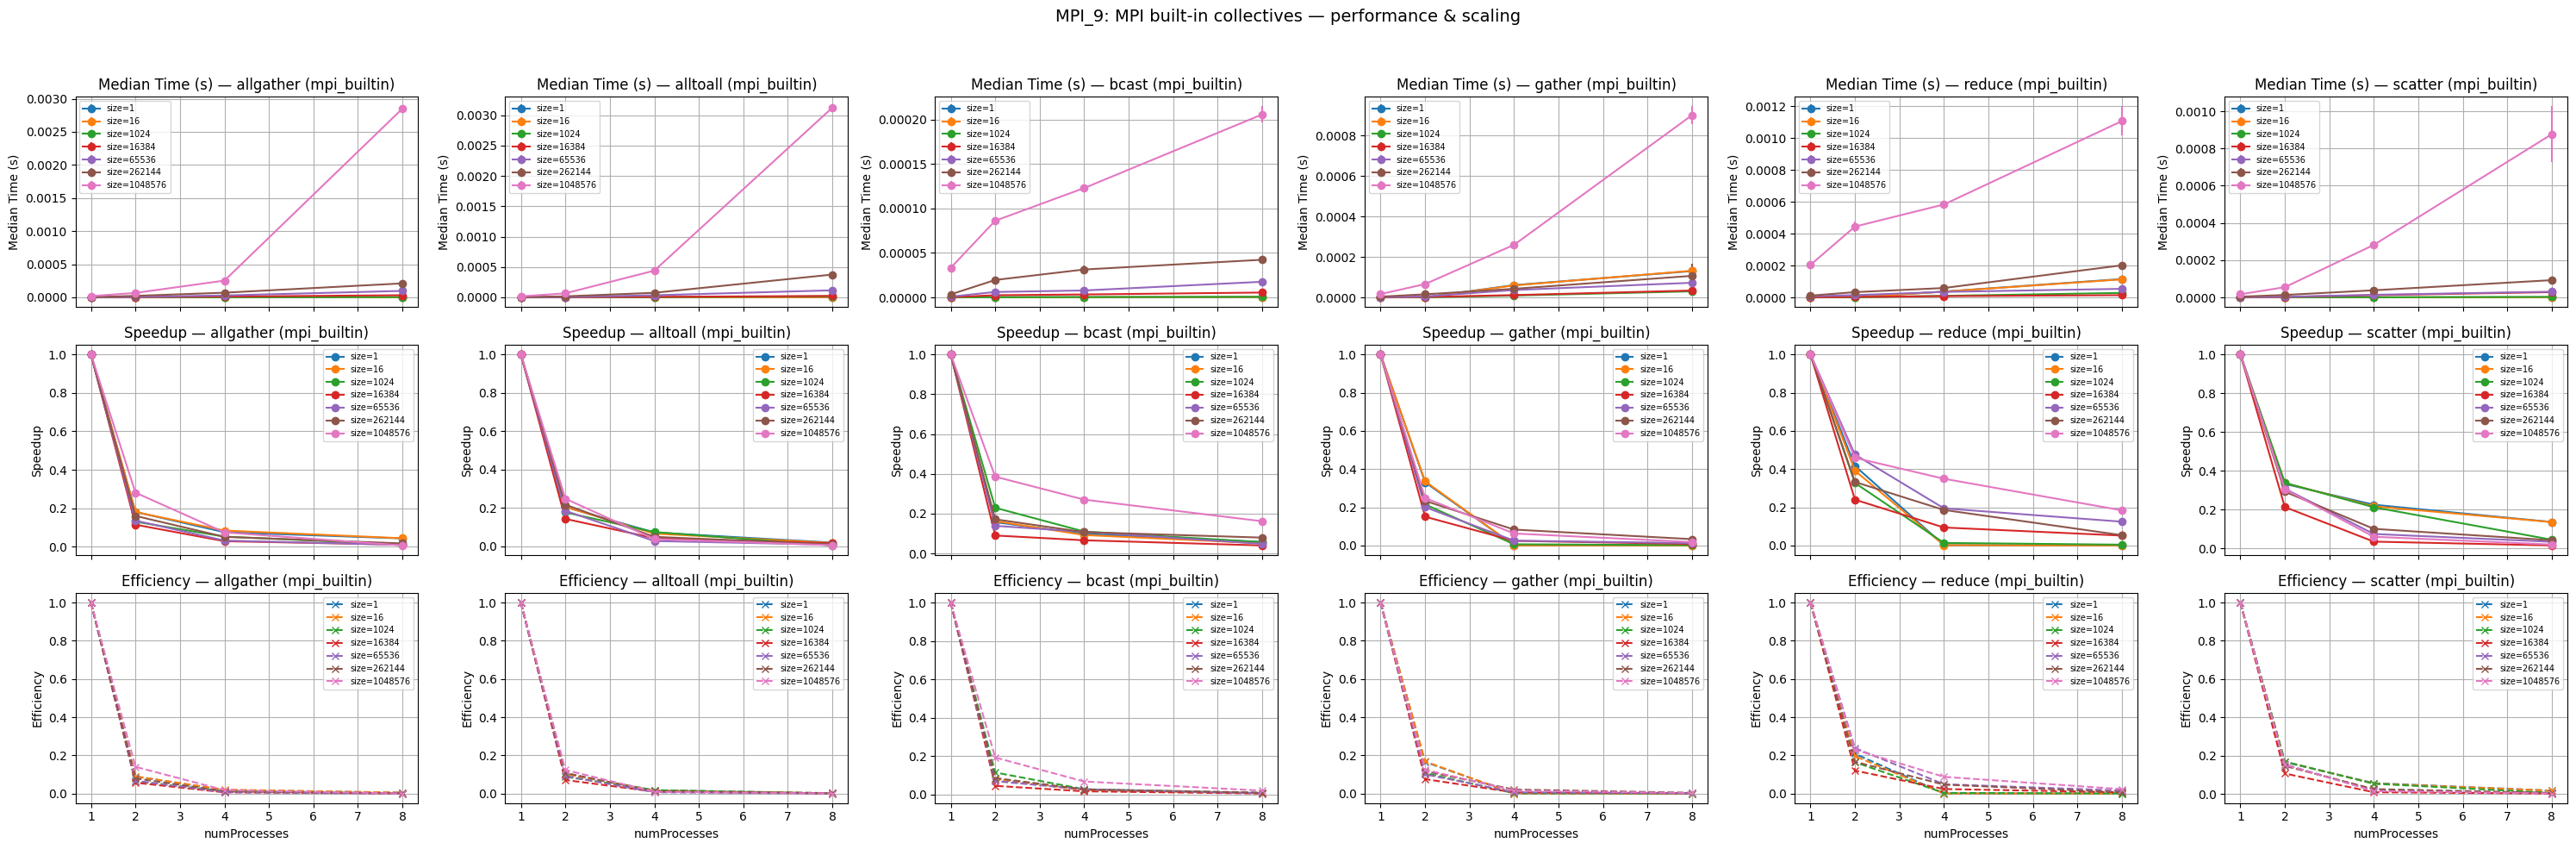

In [ ]:
metrics = ["median","speedup","efficiency"]
metricLabels = {"median":"Median Time (s)","speedup":"Speedup","efficiency":"Efficiency"}
opsCustom = sorted(perfFrameCustom["opName"].unique())

fig, axes = plt.subplots(len(metrics), max(1,len(opsCustom)), figsize=(5 * max(1,len(opsCustom)), 10), sharex=True)
if len(opsCustom) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

messageSizes = sorted(perfFrameCustom["messageSizeBytes"].unique())

for colIdx, opVal in enumerate(opsCustom):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for messageSizeVal in messageSizes:
            subFrame = perfFrameCustom[(perfFrameCustom["opName"] == opVal) & (perfFrameCustom["messageSizeBytes"] == messageSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={messageSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={messageSizeVal}")
        if not anyPlotted:
            ax.text(0.5,0.5,"no data",ha='center',va='center')
        ax.set_title(f"{metricLabels[metric]} — {opVal} (custom)")
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=7)

plt.suptitle("MPI_9: custom implementations — performance & scaling", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


opsMpi = sorted(perfFrameMpi["opName"].unique())
messageSizesMpi = sorted(perfFrameMpi["messageSizeBytes"].unique())

fig, axes = plt.subplots(len(metrics), max(1,len(opsMpi)), figsize=(5 * max(1,len(opsMpi)), 10), sharex=True)
if len(opsMpi) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, opVal in enumerate(opsMpi):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for messageSizeVal in messageSizesMpi:
            subFrame = perfFrameMpi[(perfFrameMpi["opName"] == opVal) & (perfFrameMpi["messageSizeBytes"] == messageSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={messageSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={messageSizeVal}")
        if not anyPlotted:
            ax.text(0.5,0.5,"no data",ha='center',va='center')
        ax.set_title(f"{metricLabels[metric]} — {opVal} (mpi_builtin)")
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=7)

plt.suptitle("MPI_9: MPI built-in collectives — performance & scaling", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

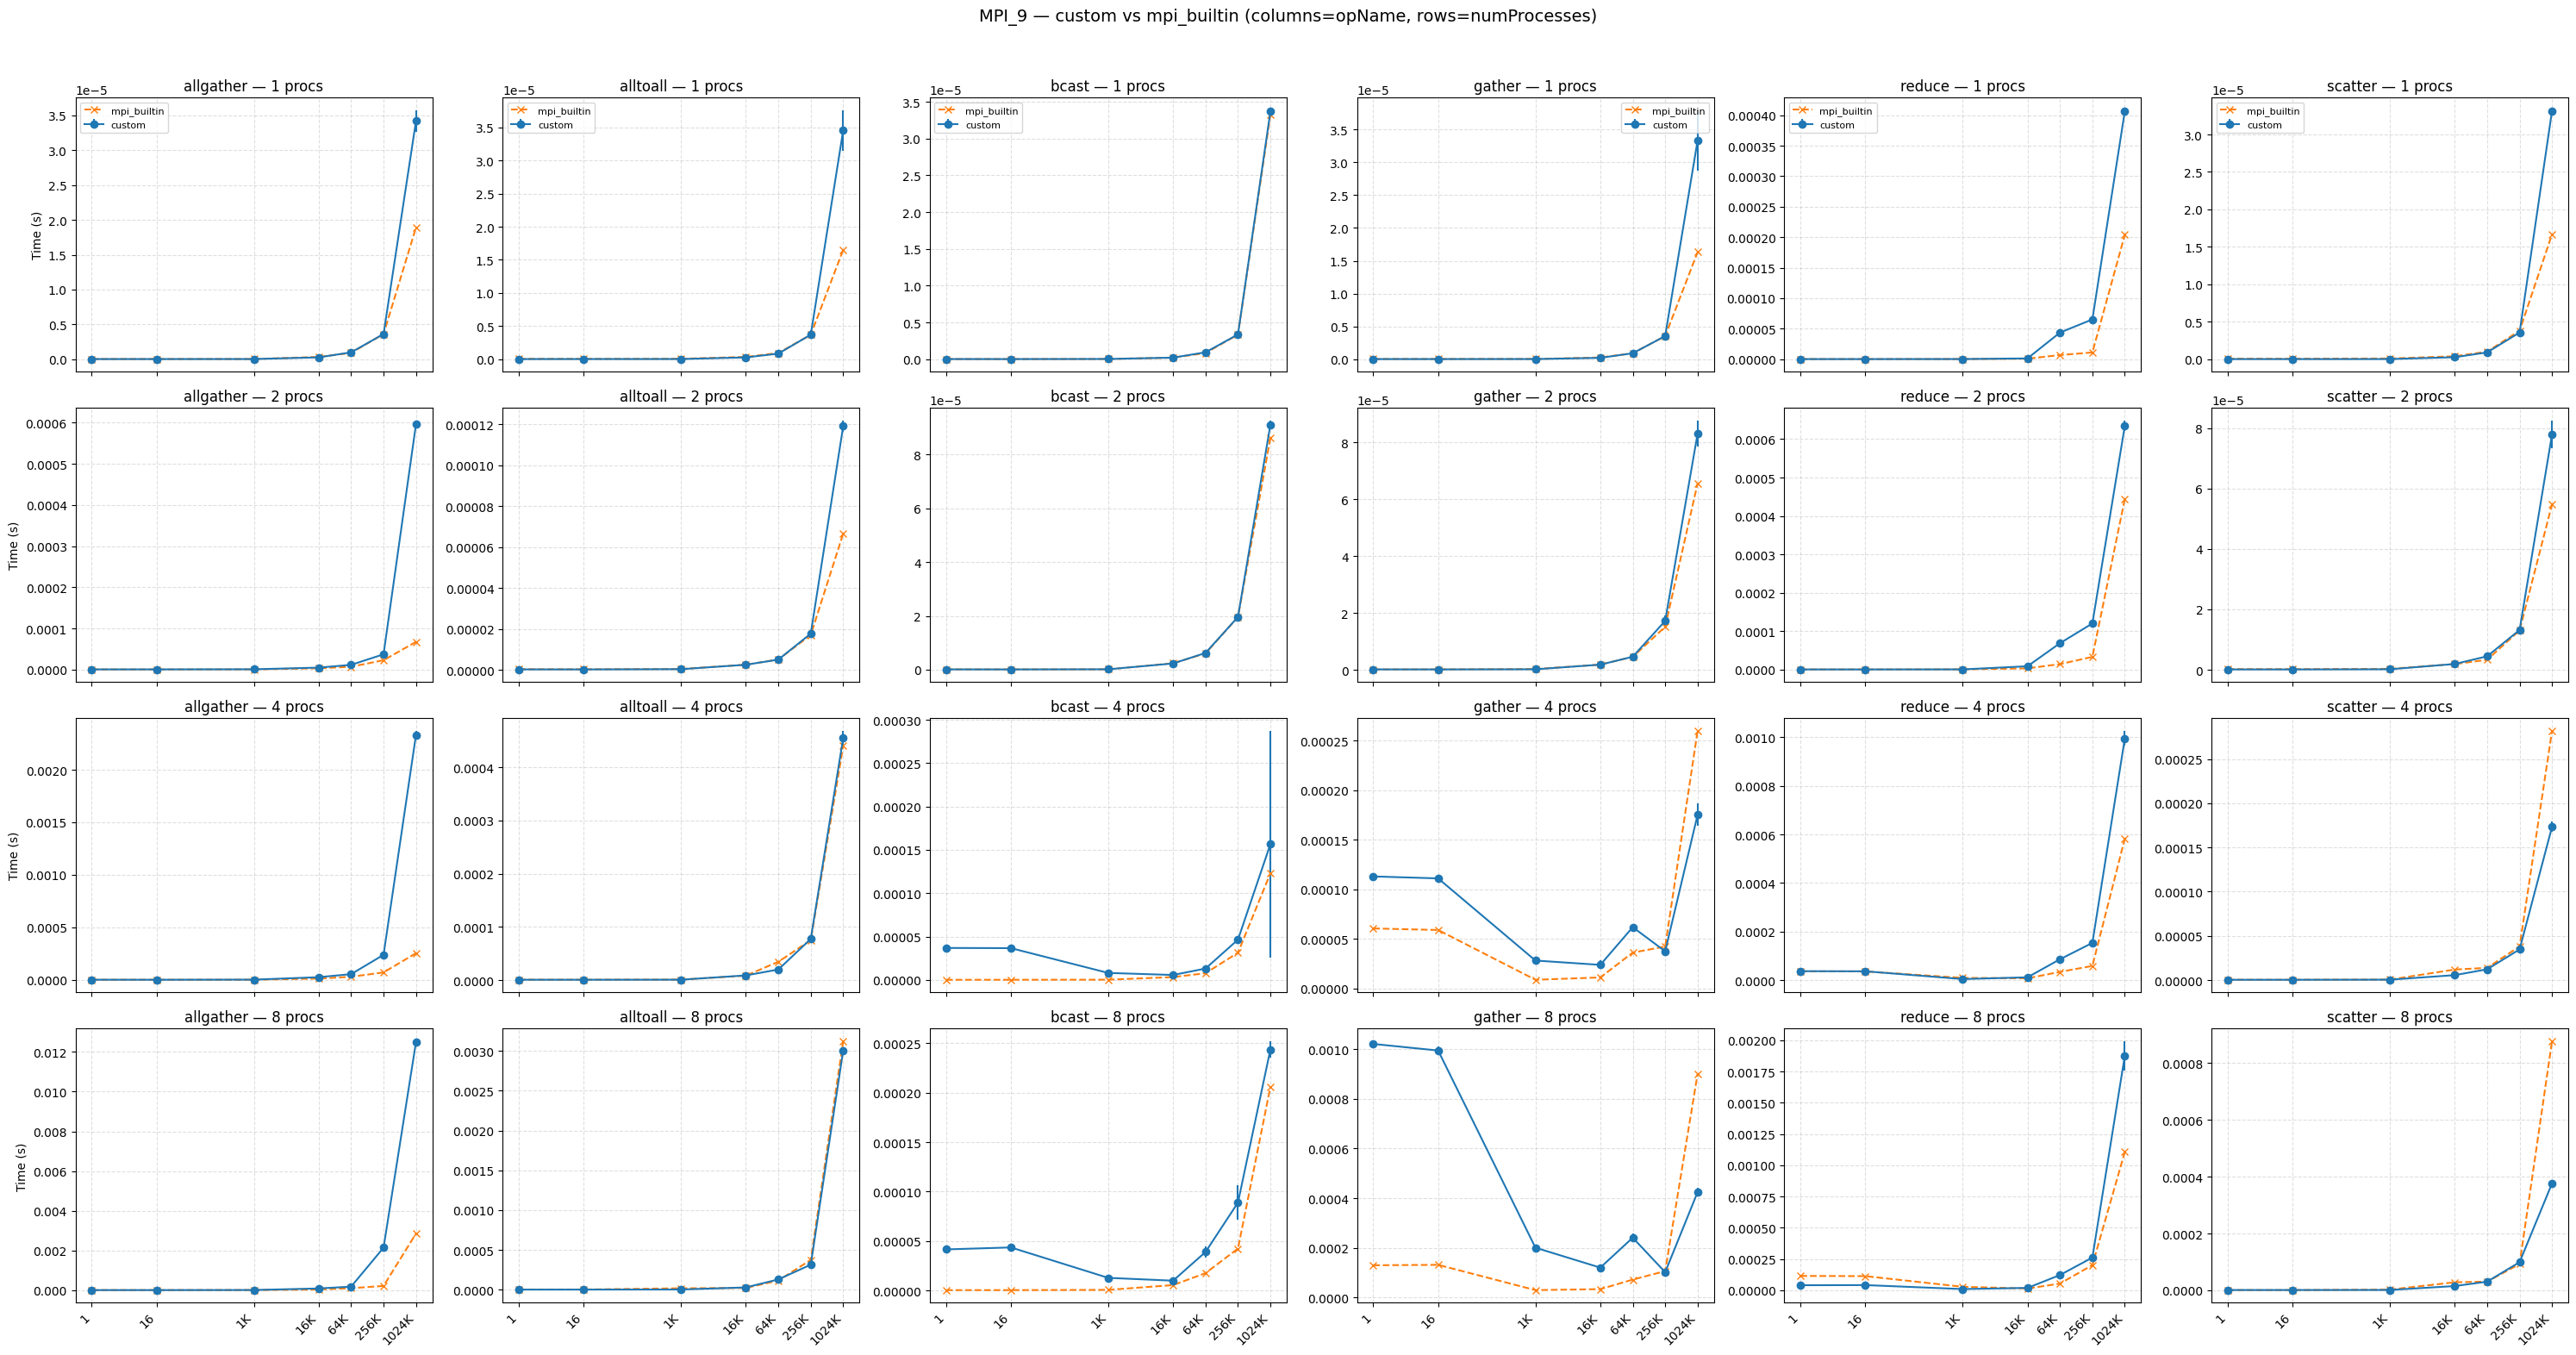

In [27]:
ops = sorted(grouped["opName"].unique())
procList = sorted(grouped["numProcesses"].unique())

numCols = max(1, len(ops))
numRows = max(1, len(procList))
fig, axes = plt.subplots(numRows, numCols, figsize=(5 * numCols, 4 * numRows), sharex='col')

if numRows == 1 and numCols == 1:
    axes2d = np.array([[axes]])
elif numRows == 1:
    axes2d = np.array([axes])
elif numCols == 1:
    axes2d = np.array([[ax] for ax in axes])
else:
    axes2d = axes

for colIdx, opVal in enumerate(ops):
    for rowIdx, p in enumerate(procList):
        ax = axes2d[rowIdx][colIdx]
        sub = grouped[(grouped["opName"] == opVal) & (grouped["numProcesses"] == p)].sort_values("messageSizeBytes")
        if sub.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_title(f"{opVal} — {p} procs")
            ax.grid(True)
            continue

        x = sub["messageSizeBytes"].values
        yCustom = sub["medianCustom"].values
        yMpi = sub["medianMpi"].values
        yerrCustom = sub["stdCustom"].values

        ax.set_xscale("log", base=2)
        ax.errorbar(x, yCustom, yerr=yerrCustom, marker='o', linestyle='-', label='custom')
        ax.plot(x, yMpi, marker='x', linestyle='--', label='mpi_builtin')

        ax.set_title(f"{opVal} — {p} procs")
        ax.grid(True, which='both', linestyle='--', alpha=0.4)
        if rowIdx == numRows - 1:
            xticks = x
            maxTicks = 8
            if len(xticks) > maxTicks:
                indices = np.linspace(0, len(xticks) - 1, maxTicks, dtype=int)
                xticks = [xticks[i] for i in indices]
            ax.set_xticks(xticks)
            def humanLabel(n):
                if n >= 1024:
                    if n % 1024 == 0:
                        return f"{n//1024}K"
                    return f"{n/1024:.1f}K"
                return str(n)
            ax.set_xticklabels([humanLabel(v) for v in xticks], rotation=45, ha='right')
        if colIdx == 0:
            ax.set_ylabel("Time (s)")
        if rowIdx == 0:
            ax.legend(fontsize=8)

plt.suptitle("MPI_9 — custom vs mpi_builtin (columns=opName, rows=numProcesses)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [29]:
grouped["ratioMpiOverCustom"] = grouped["medianMpi"] / grouped["medianCustom"]
pivot = grouped.pivot_table(index=["messageSizeBytes","numProcesses"], columns="opName", values="ratioMpiOverCustom")
display(pivot.head(20))


opName                         allgather  alltoall     bcast    gather  \
messageSizeBytes numProcesses                                            
1                1              1.076923  1.970588  0.807692  1.263158   
                 2              0.625337  1.338776  1.007519  1.006944   
                 4              0.499551  1.079677  0.005797  0.536417   
                 8              0.519293  1.421755  0.008811  0.127336   
16               1              1.050000  1.605263  0.863636  1.236842   
                 2              0.638356  1.302632  1.000000  1.029412   
                 4              0.582264  1.081967  0.005614  0.531952   
                 8              0.488718  1.429315  0.008618  0.132388   
1024             1              1.119048  1.950000  1.028571  1.439024   
                 2              0.558824  1.259259  0.945783  1.481081   
                 4              0.475610  1.073394  0.040464  0.315572   
                 8              0.654167  5.289354  0.049996  0.148852   
16384            1              1.230496  1.275618  0.990868  1.237668   
                 2              0.649292  1.005567  1.035607  1.010491   
                 4              0.481662  0.949744  0.574139  0.471337   
                 8              0.384416  0.791256  0.548690  0.281354   
65536            1              0.923000  1.100585  0.892895  0.997828   
                 2              0.595894  1.014539  0.973895  0.994560   
                 4              0.532638  1.724586  0.589395  0.586539   
                 8              0.554366  0.891003  0.451079  0.299723   

opName                           reduce   scatter  
messageSizeBytes numProcesses                      
1                1             1.025641  2.333333  
                 2             0.989691  1.770992  
                 4             0.981477  1.071875  
                 8             2.843411  0.607257  
16               1             1.104478  2.500000  
                 2             0.974227  1.728682  
                 4             0.984436  1.070988  
                 8             2.723263  0.589172  
1024             1             0.898649  3.343750  
                 2             1.150142  1.761111  
                 4             2.043876  1.137079  
                 8             2.894033  2.185085  
16384            1             0.613311  1.458484  
                 2             0.357471  0.986508  
                 4             0.643514  2.136641  
                 8             0.731450  1.891560  
65536            1             0.153742  1.104348  
                 2             0.205152  0.740103  
                 4             0.398619  1.134279  
                 8             0.439407  1.007146